<a href="https://colab.research.google.com/github/RaduSima/SSL_Project2024/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ! pip install datasets
# ! pip install -U accelerate
# ! pip install -U transformers

import ast
import itertools

import pandas as pd
from transformers import Trainer, TrainingArguments

from architectures import OurDifficultyClassifierModel, OurTagClassifierModel
from utils import (compute_metrics_difficulty_classifier,
                   compute_metrics_tag_classifier, get_model_class_from_name,
                   maybe_load_embeddings,
                   prepare_dataset_difficulty_classifier,
                   prepare_dataset_tag_classifier,
                   prepare_finetune_dataset_difficulty_classifier,
                   prepare_finetune_dataset_tag_classifier, save_torch_model,
                   transformers_classes, 
                   create_metrics_difficulty_function,
                   create_metrics_tag_function,
                   transformers_repo)

c:\Users\Stefan.saraev\Anaconda3\envs\e2_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


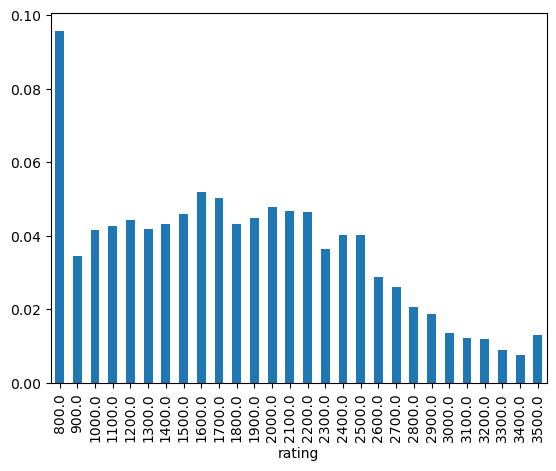

In [3]:
import matplotlib.pyplot as plt
train_data = pd.read_csv('./data/AMT10/AMT10_train.csv')
val_data = pd.read_csv('./data/AMT10/AMT10_validation.csv')
test_data = pd.read_csv('./data/AMT10/AMT10_test.csv')

train_texts, train_difficulty_ratings, train_tags = train_data['description'].tolist(), train_data['rating'].tolist(), train_data['tags'].tolist()
val_texts, val_difficulty_ratings, val_tags = val_data['description'].tolist(), val_data['rating'].tolist(), val_data['tags'].tolist()
test_texts, test_difficulty_ratings, test_tags = test_data['description'].tolist(), test_data['rating'].tolist(), test_data['tags'].tolist()

train_tags = [ast.literal_eval(tags) for tags in train_tags]
val_tags = [ast.literal_eval(tags) for tags in val_tags]
test_tags = [ast.literal_eval(tags) for tags in test_tags]

all_tags = sorted(list(set(itertools.chain.from_iterable(train_tags + val_tags + test_tags))))
tag2id = {tag: i for i, tag in enumerate(all_tags)}
id2tag = {i: tag for i, tag in enumerate(all_tags)}

rating_distribution = train_data['rating'].value_counts().sort_index()
rating_distribution = rating_distribution / rating_distribution.sum()
# plot the distribution
rating_distribution.plot(kind='bar')
plt.show()

In [ ]:
def train_and_finetune_tag_classifier(transformer_name, train_texts, train_tags, val_texts, val_tags, test_texts, test_tags, intermediate_layers, tag2id):
    base_model = transformers_classes[transformer_name]["model_class"].from_pretrained(transformer_name)
    embedding_size = transformers_classes[transformer_name]["embedding_size"]

    train_dataset=prepare_finetune_dataset_tag_classifier(transformer_name, train_texts, train_tags, tag2id)
    val_dataset=prepare_finetune_dataset_tag_classifier(transformer_name, val_texts, val_tags, tag2id)
    test_dataset=prepare_finetune_dataset_tag_classifier(transformer_name, test_texts, test_tags, tag2id)

    model = OurTagClassifierModel(base_model, embedding_size, len(tag2id), intermediate_layers=intermediate_layers)
    
    training_args = TrainingArguments(
      learning_rate=1e-4,
      output_dir="./results",
      num_train_epochs=100,
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      warmup_steps=500,
      weight_decay=0.01,
      logging_dir="./logs",
      metric_for_best_model="f1"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_tag_classifier
    )

    trainer.train()

    # Evaluate the model on the testing set
    eval_results = trainer.evaluate(test_dataset)
    print(eval_results)

    save_torch_model(
        trainer.model,
        {"tag2id": tag2id, "intermediate_layers": intermediate_layers, 'model_class': OurTagClassifierModel},
        f"{transformer_name.replace('/', '_')}_transformer_tag_classifier"
    )
    # save scores
    with open(f'./results/{transformer_name.replace("/", "_")}__transformer_tag_classifier_scores.txt', 'w') as f:
        f.write(str(eval_results))
    
    return eval_results

In [ ]:
def train_and_finetune_difficulty_classifier(transformer_name, train_texts, train_difficulty_ratings, val_texts, val_difficulty_ratings, test_texts, test_difficulty_ratings, intermediate_layers, num_classes):
    base_model = transformers_classes[transformer_name]["model_class"].from_pretrained(
        transformer_name)
    embedding_size = transformers_classes[transformer_name]["embedding_size"]

    train_dataset = prepare_finetune_dataset_difficulty_classifier(
        transformer_name, train_texts, train_difficulty_ratings, num_classes=num_classes)
    val_dataset = prepare_finetune_dataset_difficulty_classifier(
        transformer_name, val_texts, val_difficulty_ratings, num_classes=num_classes)
    test_dataset = prepare_finetune_dataset_difficulty_classifier(
        transformer_name, test_texts, test_difficulty_ratings, num_classes=num_classes)

    model = OurDifficultyClassifierModel(
        base_model, embedding_size, num_classes, intermediate_layers)

    training_args = TrainingArguments(
        learning_rate=1e-5,
        output_dir="./results",
        num_train_epochs=100,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        metric_for_best_model="neighborhood_accuracy"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_difficulty_classifier
    )

    trainer.train()

    # Evaluate the model on the testing set
    eval_results = trainer.evaluate(test_dataset)
    print(eval_results)

    save_torch_model(
        trainer.model,
        {"num_classes": num_classes, "intermediate_layers": intermediate_layers, 'model_class': OurDifficultyClassifierModel},
        f"{transformer_name.replace('/', '_')}_transformer_difficulty_classifier"
    )

    # save scores
    with open(f"{transformer_name.replace('/', '_')}_transformer_difficulty_classifier_scores.txt", "w") as f:
        f.write(str(eval_results))

    return eval_results

In [ ]:
def train_grid_search_tag_classifier(transformer_name, train_texts, train_tags, val_texts, val_tags, test_texts, test_tags, metric_compare_grid_results, param_grid):
    train_embeddings = maybe_load_embeddings(
        transformer_name, train_texts, "train", "./data/AMT10")
    val_embeddings = maybe_load_embeddings(
        transformer_name, val_texts, "val", "./data/AMT10")
    test_embeddings = maybe_load_embeddings(
        transformer_name, test_texts, "test", "./data/AMT10")

    param_combinations = list(itertools.product(*param_grid.values()))
    embedding_size = transformers_classes[transformer_name]["embedding_size"]

    best_eval_metric = float('-inf')
    best_params = None
    best_trainer = None

    results = []

    for params in param_combinations:
        params = dict(zip(param_grid.keys(), params))
        learning_rate = params['learning_rate']
        train_batch_size = params['per_device_train_batch_size']
        num_epochs = params['num_train_epochs']
        model_class = get_model_class_from_name(params['model_class'])
        num_classes = len(tag2id)
        intermediate_layers = params['intermediate_layers']
        train_metric = params['train_metric']
        threshold = params['threshold']
        metrics_function = create_metrics_tag_function(threshold)

        to_train_model = model_class(
            embedding_size=embedding_size, num_classes=num_classes, intermediate_layers=intermediate_layers)

        train_dataset = prepare_dataset_tag_classifier(
            train_embeddings, train_tags, tag2id)
        val_dataset = prepare_dataset_tag_classifier(
            val_embeddings, val_tags, tag2id)
        test_dataset = prepare_dataset_tag_classifier(
            test_embeddings, test_tags, tag2id)

        training_args = TrainingArguments(
            learning_rate=learning_rate,
            output_dir="./results",
            num_train_epochs=num_epochs,
            per_device_train_batch_size=train_batch_size,
            per_device_eval_batch_size=train_batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir="./logs",
            metric_for_best_model=train_metric
        )

        trainer = Trainer(
            model=to_train_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=metrics_function
        )

        trainer.train()

        eval_results = trainer.evaluate(test_dataset)

        print(eval_results)

        eval_metric = eval_results[f'eval_{metric_compare_grid_results}']
        
        result_entry = params.copy()
        for key in eval_results.keys():
            result_entry[key] = eval_results[key]
        results.append(result_entry)

        if eval_metric > best_eval_metric:
            best_eval_metric = eval_metric
            best_params = params
            best_trainer = trainer

    print(
        f"Best Evaluation Metric: {metric_compare_grid_results}: {best_eval_metric}")
    print(f"Best Hyperparameters: {best_params}")

    # Evaluate the model on the testing set
    test_dataset = prepare_dataset_tag_classifier(
        test_embeddings, test_tags, tag2id)
    best_eval_results = best_trainer.evaluate(test_dataset)
    print(best_eval_results)

    best_model_hyperparams = {
        "tag2id": tag2id,
        "transformer_name": transformer_name,
        "embedding_size": embedding_size,
        "num_classes": len(tag2id),
        "intermediate_layers": best_params['intermediate_layers'],
        "model_class": best_params['model_class']
    }

    save_torch_model(
        best_trainer.model,
        best_model_hyperparams,
        f"{transformer_name.replace('/', '_')}_tag_classifier"
    )
    # save scores
    with open(f"{transformer_name.replace('/', '_')}_tag_classifier_scores.txt", "w") as f:
        f.write(str(best_eval_results))
        
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{transformer_name.replace('/', '_')}_grid_search_tag_results.csv", index=False)

    return best_params, best_eval_results

In [ ]:
def train_grid_search_difficulty_classifier(transformer_name, train_texts, train_difficulty_ratings, val_texts, val_difficulty_ratings, test_texts, test_difficulty_ratings, metric_compare_grid_results, param_grid):
    train_embeddings = maybe_load_embeddings(
        transformer_name, train_texts, "train", "./data/AMT10")
    val_embeddings = maybe_load_embeddings(
        transformer_name, val_texts, "val", "./data/AMT10")
    test_embeddings = maybe_load_embeddings(
        transformer_name, test_texts, "test", "./data/AMT10")

    param_combinations = list(itertools.product(*param_grid.values()))
    embedding_size = transformers_classes[transformer_name]["embedding_size"]

    best_eval_metric = float('-inf')
    best_params = None
    best_trainer = None

    results = []

    for params in param_combinations:
        params = dict(zip(param_grid.keys(), params))
        learning_rate = params['learning_rate']
        train_batch_size = params['per_device_train_batch_size']
        num_epochs = params['num_train_epochs']
        model_class = get_model_class_from_name(params['model_class'])
        num_classes = params['num_classes']
        intermediate_layers = params['intermediate_layers']
        train_metric = params['train_metric']
        threshold = params['threshold']
        metrics_function = create_metrics_difficulty_function(threshold)

        to_train_model = model_class(
            embedding_size=embedding_size, num_classes=num_classes, intermediate_layers=intermediate_layers)

        train_dataset = prepare_dataset_difficulty_classifier(
            train_embeddings, train_difficulty_ratings, num_classes=num_classes)
        val_dataset = prepare_dataset_difficulty_classifier(
            val_embeddings, val_difficulty_ratings, num_classes=num_classes)
        test_dataset = prepare_dataset_difficulty_classifier(
            test_embeddings, test_difficulty_ratings, num_classes=num_classes)

        training_args = TrainingArguments(
            learning_rate=learning_rate,
            output_dir="./results",
            num_train_epochs=num_epochs,
            per_device_train_batch_size=train_batch_size,
            per_device_eval_batch_size=train_batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir="./logs",
            metric_for_best_model=train_metric
        )

        trainer = Trainer(
            model=to_train_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=metrics_function
        )

        trainer.train()

        eval_results = trainer.evaluate(test_dataset)

        eval_metric = eval_results[f'eval_{metric_compare_grid_results}']
        
        result_entry = params.copy()
        
        for key in eval_results.keys():
            result_entry[key] = eval_results[key]
        
        results.append(result_entry)

        if eval_metric > best_eval_metric:
            best_eval_metric = eval_metric
            best_params = params
            best_trainer = trainer

    print(
        f"Best Evaluation Metric: {metric_compare_grid_results}: {best_eval_metric}")
    print(f"Best Hyperparameters: {best_params}")

    # Evaluate the model on the testing set
    test_dataset = prepare_dataset_difficulty_classifier(
        test_embeddings, test_difficulty_ratings, num_classes=best_params['num_classes'])
    best_eval_results = best_trainer.evaluate(test_dataset)
    print(best_eval_results)

    best_model_hyperparams = {
        "transformer_name": transformer_name,
        "num_classes": best_params['num_classes'],
        "embedding_size": embedding_size,
        "intermediate_layers": best_params['intermediate_layers'],
        "model_class": best_params['model_class']
    }

    save_torch_model(
        best_trainer.model,
        best_model_hyperparams,
        f"{transformer_name.replace('/', '_')}_difficulty_classifier"
    )
    # save scores
    with open(f"{transformer_name.replace('/', '_')}_difficulty_classifier_scores.txt", "w") as f:
        f.write(str(best_eval_results))
        
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{transformer_name.replace('/', '_')}_grid_search_difficulty_results.csv", index=False)
    
    return best_params, best_eval_results, results_df

In [ ]:
# Train grid search difficulty classifier
param_grid = {
    'learning_rate': [
        1e-4,
    ],
    'per_device_train_batch_size': [
        8 # could be bigger (1024, 2048)
    ],
    'num_train_epochs': [
        10, # could be bigger (500, 1000)
    ],
    "train_metric": [
        "neighborhood_accuracy",
        "accuracy",
    ],

    # Model
    'model_class': [
        'OrdinalRegressionClassifier',
    ],
    'num_classes': [
        5,
        # 10,
        28
    ],
    'intermediate_layers': [
        [256, 128, 64, 32],
        [512, 128, 32],
        [256, 64, 16],
    ],
    'threshold': [
        # 0.25,
        0.35,
        0.5,
    ]
}

transformer_name = "google/bigbird-roberta-large"
# transformer_name = "t5-small"

best_difficulty_classifier_params, best_difficulty_classifier_eval_results = train_grid_search_difficulty_classifier(transformer_name, train_texts, train_difficulty_ratings, val_texts, val_difficulty_ratings, test_texts, test_difficulty_ratings, "neighborhood_accuracy", param_grid)

In [ ]:
best_difficulty_classifier_eval_results

In [ ]:
best_difficulty_classifier_params

In [ ]:
# Train grid search tag classifier
param_grid = {
    'learning_rate': [
        1e-4,
    ],
    'per_device_train_batch_size': [
        8 # could be bigger (1024, 2048)
    ],
    'num_train_epochs': [
        10, # could be bigger (500, 1000)
    ],
    "train_metric": [
        "accuracy",
        "f1"
    ],
    # Model
    'model_class': [
        'TagClassifier',
    ],
    'intermediate_layers': [
        [256, 128, 64, 32],
        [512, 128, 32],
        [256, 64, 16],
    ],
    'threshold': [
        0.25,
        0.35,
        0.5
    ]
}

transformer_name = "google/bigbird-roberta-large"
# transformer_name = "t5-small"

best_tag_classifier_params, best_tag_classifier_eval_results = train_grid_search_tag_classifier(transformer_name, train_texts, train_tags, val_texts, val_tags, test_texts, test_tags, "f1", param_grid)

In [ ]:
best_tag_classifier_eval_results

In [ ]:
best_tag_classifier_params

In [ ]:
# full_difficulty_classifier_model_eval_results = train_and_finetune_difficulty_classifier(transformer_name, train_texts, train_difficulty_ratings, val_texts, val_difficulty_ratings, test_texts, test_difficulty_ratings, best_difficulty_classifier_params['intermediate_layers'], best_difficulty_classifier_params['num_classes'])

In [ ]:
# full_tag_classifier_model_eval_results = train_and_finetune_tag_classifier(transformer_name, train_texts, train_tags, val_texts, val_tags, test_texts, test_tags, best_tag_classifier_params['intermediate_layers'])